In [210]:
#dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine 
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, inspect, func


In [211]:
engine = create_engine("sqlite:///hawaii.sqlite")



In [212]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [213]:
Measurements = Base.classes.measurements

In [214]:
Stations = Base.classes.stations

In [215]:
session = Session(engine)

Precipitation Analysis

In [216]:
check_measurements = session.query(Measurements).first()

In [217]:
check_measurements.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x17ebde7b0f0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

In [218]:
#Most recent date by descending.first
most_recent = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
most_recent_list = most_recent[0].split("-")#split on "-"
most_recent_list#check

['2017', '08', '23']

In [219]:
#convert index 0 value to integer to perform math
year_before = int(most_recent_list [0])-1
year_before#check

2016

In [220]:
#convert back to string and combine
year_ago = str(year_before)+"-"+most_recent_list[1]+"-"+most_recent_list[2]
year_ago#check

'2016-08-23'

In [221]:
#session query
year_prcp = session.query(Measurements.date, Measurements.prcp).order_by(Measurements.date).filter(Measurements.date > year_ago)

In [222]:
year_prcp#check

In [223]:
#write to data frame
year_prcp_df = pd.read_sql_query(year_prcp.statement, engine,index_col = 'date')
year_prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


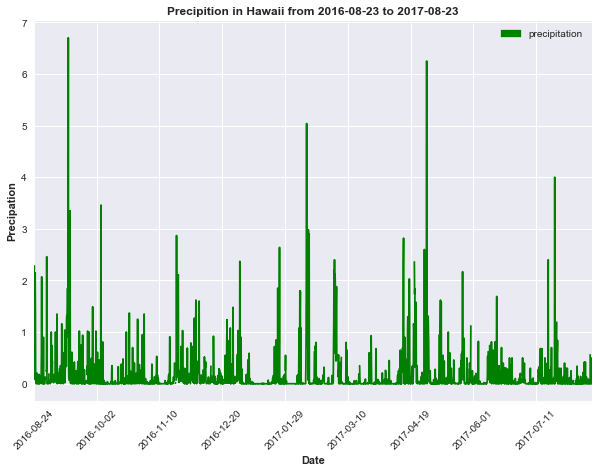

In [236]:
#plot graph no.1
sns.set()
year_prcp_df.plot(figsize = (10,7),rot = 45, use_index = True, legend=True, color='G')
plt.ylabel('Precipation', fontweight = 'bold')
plt.xlabel('Date', fontweight = 'bold')
plt.title("Precipition in Hawaii from %s to %s" % (year_ago,most_recent[0]), fontweight = 'bold')
green_patch = mpatches.Patch(color='Green', label='precipitation')
plt.legend(handles=[green_patch])
plt.show()

Station Analysis

In [237]:
#inspect station data
station_data = session.query(Stations).first()
station_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x17ebdb80f98>,
 'elevation': '3',
 'id': 1,
 'latitude': '21.2716',
 'location': 'POINT(21.2716 -157.8168)',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [238]:
#get station count, has been checked with measurement station count
station_count = session.query(Stations.station).group_by(Stations.station).count()

In [239]:
station_count#check

9

In [240]:
#query tables to get count of daily report, all temp data is complete for each record, so the count
#reflects a count of a station giving temp data, prcp data may or may not have been reported on that date
temp_data_query = session.query(Stations.station, Stations.name, Measurements.station, func.count(Measurements.tobs)).filter(Stations.station == Measurements.station).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).all()

In [241]:
temp_data_query

[('USC00519281', 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 'USC00517948', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [242]:
#hard code most active station
most_activity = temp_data_query[0][0:2]
most_activity

('USC00519281', 'WAIHEE 837.5, HI US')

In [243]:
# the number of reports from the most active station
temps_mosact = session.query(Measurements.station, Measurements.tobs).filter(Measurements.station == most_activity[0], Measurements.date > year_ago).all()

In [244]:
len(temps_mosact)

351

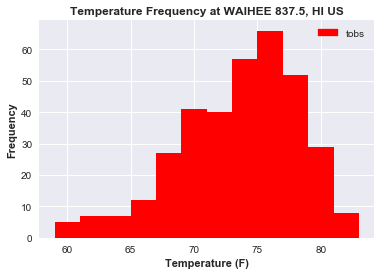

In [245]:
# list created from temperature data query from the most active station
sns.set()
temps = [x[1] for x in temps_mosact]
plt.hist(temps, bins=12, color='R')
plt.xlabel("Temperature (F)", fontweight = 'bold')
plt.ylabel("Frequency", fontweight = 'bold')
plt.title("Temperature Frequency at %s" % (most_activity[1]), fontweight = 'bold')
red_patch = mpatches.Patch(color='red', label='tobs')
plt.legend(handles=[red_patch])
plt.show()

Temperature Analysis

In [248]:
def calc_temps(start_date, end_date):
    #create dates 1 year prior
    dates = [start_date, end_date]
    new_dates = []
    for date in dates:
        date_list = date.split("-")
        date_list[0] = str(int(date_list[0]) - 1)
        new_date = "-".join(date_list)
        new_dates.append(new_date)
    print(new_dates) 
    
    #query database for temps from those dates
    temp_values = session.query(Measurements.tobs).filter(Measurements.date >= new_dates[0], Measurements.date <= new_dates[1]).all()
    temp_values_list = [x for (x,) in temp_values]
    avg_temp = np.mean(temp_values_list)
    max_temp = max(temp_values_list)
    min_temp = min(temp_values_list)
    
    # create bar graph
    plt.figure(figsize=(2,5))
    plt.title("Trip Avg Temp", fontweight = 'bold')
    plt.ylabel("Temperature (F)",fontweight = 'bold')
    plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "",color='Y')
    plt.show()

['2017-08-01', '2017-08-14']


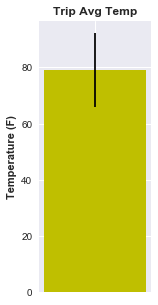

In [249]:
calc_temps('2018-08-01', '2018-08-14')

Optional Recommended Analysis

In [270]:
#query to return list of temps for each date
def daily_normals(chosen_date):
    temps = session.query(Measurements.tobs).filter(Measurements.date.like('%'+chosen_date)).all()
    obs = [x for (x), in temps]
    return obs
    
start_date = '08-23'
end_date = '09-04'

#function to generate list of dates given any start and end date
def create_date_list(start_date, end_date):
    start_month = start_date.split("-")[0]
    end_month = end_date.split("-")[0]
    
    start_day = int(start_date.split("-")[1])
    end_day = int(end_date.split("-")[1])
    
    if start_month == end_month:
        diff = end_day - start_day
        days = [start_day + x for x in range(0,diff + 1) ]
    
    else:
        diff1 = 31 - start_day
        days1 = [start_day + x for x in range(0,diff1 + 1)]
        days2 = [x for x in range(1, end_day + 1)]
        days = days1 + days2
        
    days_str = [('%s-%s' % (start_month, str(x))) if len(str(x)) == 2 else ('%s-0%s' % (end_month, str(x))) for x in days]
    return days_str

#uses functions above to return dictionary of normals, skips dates for which there is no data (false dates)
def query_results(start, end):
    dates = create_date_list(start, end)
    master_dict = {"Date": [], "tmax": [], "tmin": [], "tavg": []}
    for date in dates:
        data_list = []
        observations = daily_normals(date)
        if observations != []:
            for temp in observations:
                data_list.append(temp)
            master_dict['Date'].append(date)
            master_dict['tmax'].append(max(data_list))
            master_dict['tmin'].append(min(data_list))
            master_dict['tavg'].append(round(np.mean(data_list),2))
            master_dict
    return(master_dict)
    
normals_df = pd.DataFrame(query_results('08-03', '08-15')).set_index('Date')
normals_df

,tavg,tmax,tmin
Date,,,
08-03,76.61,85,70
08-04,76.71,84,69
08-05,76.15,82,69
08-06,76.25,83,67
08-07,77.16,83,71
08-08,76.56,83,68
08-09,75.98,81,69
08-10,76.42,83,65
08-11,75.98,82,67


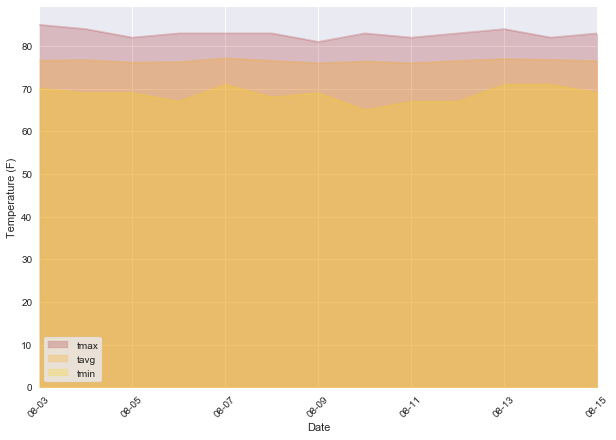

In [271]:
normals_df = normals_df[['tmax', 'tavg', 'tmin']]

normals_df.plot(kind = 'area', stacked = False, alpha = .25, rot = 45, color = ['brown', 'orange', 'gold'], figsize = (10,7), linestyle = 'solid')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.legend(frameon = True)
plt.show()